# Data visualization around the Grenoble 2020 elections - tweets

## Loading the data

In [1]:
%load_ext autoreload
%autoreload 2
import pandas
import os
from plotnine import *
import plotnine
plotnine.options.figure_size = (12, 8)
import twitter as tw

In [2]:
users = {
    'EricPiolle': 'Grenoble en Commun',
    'Grenoble_Commun': 'Grenoble en Commun',
    'EmilieCChalas': 'Un Nouveau Regard sur Grenoble',
    'Chalas2020': 'Un Nouveau Regard sur Grenoble',
    'CarignonAlain': 'Grenoble le Changement',
    'onoblecourt': 'Grenoble Nouvel Air',
    'GrenobleNvAir': 'Grenoble Nouvel Air',
}
colors = {
    'Grenoble en Commun': '#00c000',
    'Un Nouveau Regard sur Grenoble': '#ffb400',
    'Grenoble le Changement': '#0066CC',
    'Grenoble Nouvel Air': '#ff8080',    
}

In [3]:
filename = 'data.csv'
if not os.path.isfile(filename):
    df = pandas.concat([tw.get_data(user, n=200, tag=tag) for user, tag in users.items()])
    df.to_csv(filename, index=False)
else:
    df = pandas.read_csv(filename)
    df['date'] = pandas.to_datetime(df['date'])
df = df[df['date'] >= pandas.to_datetime('2019-09-01')]
print(len(df), len(df.columns))

805 10


In [4]:
df.groupby('name')[['date']].agg(['min', 'max', 'count'])

date                          
                                   min                 max count
name                                                            
Alain Carignon     2019-09-01 15:13:10 2020-02-19 09:03:28   183
Emilie CHALAS      2019-09-01 15:41:58 2020-02-19 07:26:55   379
Olivier Noblecourt 2019-09-13 07:52:23 2020-02-18 16:39:03    83
Éric Piolle        2019-09-01 06:54:52 2020-02-18 18:05:51   160

In [5]:
df.sample(n=10)

,name,login,likes,retweets,text,date,in_reply,source,coordinates,geo
388,Emilie CHALAS,EmilieCChalas,8,2,"Aujourd’hui, nous fêtons le 30ème anniversaire...",2019-11-20 09:50:44,NaN,Twitter for iPhone,NaN,NaN
395,Emilie CHALAS,EmilieCChalas,8,0,En amont de son passage à l’@AssembleeNat la s...,2019-11-14 15:59:21,NaN,Twitter for iPhone,NaN,NaN
146,Éric Piolle,EricPiolle,86,39,🌳🏔️ Dans les Alpes le climat devient fou 2x pl...,2019-09-20 08:03:28,NaN,Twitter Web App,NaN,NaN
1080,Olivier Noblecourt,onoblecourt,12,5,Merci @MartineWonner de porter ces proposition...,2019-09-18 15:18:30,NaN,Twitter Web App,NaN,NaN
382,Emilie CHALAS,EmilieCChalas,26,14,Le pseudo duel qu’essaient d’installer le mair...,2019-11-22 14:12:28,NaN,Twitter for iPhone,NaN,NaN
338,Emilie CHALAS,EmilieCChalas,135,47,Rien ne peut justifier la violence et le déni ...,2019-12-08 09:15:20,NaN,Twitter for iPhone,NaN,NaN
1025,Olivier Noblecourt,onoblecourt,14,6,Municipales à Grenoble : Olivier Noblecourt pr...,2020-01-25 21:06:18,NaN,Twitter for iPad,NaN,NaN
0,Éric Piolle,EricPiolle,11,1,A tout de suite sur @f3Alpes https://t.co/r1dO...,2020-02-18 18:05:51,NaN,Twitter for Android,NaN,NaN
474,Emilie CHALAS,EmilieCChalas,12,1,#ViolencesConjugales\nMieux accueillir et orie...,2019-10-14 14:53:22,NaN,Twitter for iPhone,NaN,NaN
321,Emilie CHALAS,EmilieCChalas,12,3,Une journée ordinaire à la Papothèque du Lys R...,2019-12-13 13:22:39,NaN,Twitter for iPhone,NaN,NaN


## Daily repartition of tweets

/home/tom/.cache/pypoetry/virtualenvs/twitter-data-NGoNO7rx-py3.7/lib/python3.7/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 16 x 10 in image.
  from_inches(height, units), units), PlotnineWarning)
/home/tom/.cache/pypoetry/virtualenvs/twitter-data-NGoNO7rx-py3.7/lib/python3.7/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: /tmp/figure.png
  warn('Filename: {}'.format(filename), PlotnineWarning)


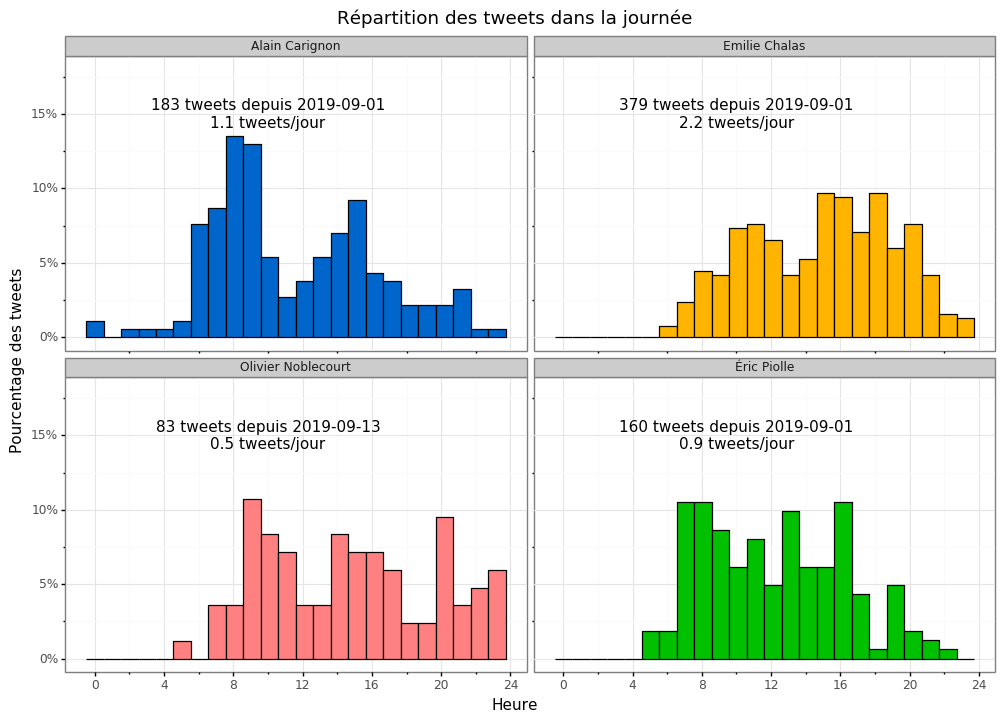

<ggplot: (-9223363276581238703)>

In [6]:
from mizani.formatters import percent_format

def format_text(row):
    return f'{row["count"]} tweets depuis {row["min"]}\n{row["intensity"]:.1f} tweets/jour'

def format_name(row):  # some candidates write their names in all-caps...
    names = row['name'].lower().split()
    names = [f'{n[0].upper()}{n[1:]}' for n in names]
    return ' '.join(names)

df['tag'] = df.apply(lambda row: users[row['login']], axis=1)
df['name'] = df.apply(format_name, axis=1)

tmp = df.groupby('name')[['date']].agg(['min', 'max', 'count']).reset_index(col_level=1)
tmp.columns = tmp.columns.droplevel()
tmp['intensity'] = tmp['count'] / (tmp['max'] - tmp['min']).dt.days
tmp['min'] = tmp['min'].dt.date
tmp['max'] = tmp['max'].dt.date
tmp['text'] = tmp.apply(format_text, axis=1)
tmp

df['time'] = pandas.to_timedelta(df['date'].dt.time.astype(str)).dt.total_seconds() / 3600  # some dirty hack
plot = ggplot(df) +\
    geom_histogram(aes(x='time', fill='tag', y='..density..'), color='black', bins=24) +\
    theme_bw() +\
    scale_fill_manual(colors) +\
    xlab('Heure') +\
    ylab('Pourcentage des tweets') +\
    labs(fill='Mouvement') +\
    facet_wrap('name') +\
    theme(legend_position='none') +\
    scale_x_continuous(breaks=range(0, 25, 4)) +\
    scale_y_continuous(labels = percent_format()) +\
    geom_text(tmp, aes(label='text'), x=10, y=0.15) + expand_limits(y=0.18) +\
    ggtitle('Répartition des tweets dans la journée')

plot.save('/tmp/figure.png', width=16, height=10)

plot

## A few summary statistics

In [7]:
df.groupby('name')[['date']].agg(['min', 'count'])

date      
                                   min count
name                                        
Alain Carignon     2019-09-01 15:13:10   183
Emilie Chalas      2019-09-01 15:41:58   379
Olivier Noblecourt 2019-09-13 07:52:23    83
Éric Piolle        2019-09-01 06:54:52   160

In [8]:
tmp = df.groupby(['name', 'source'])[['date']].count()
tmp['percentage'] = tmp.groupby(level=0).apply(lambda x: round(100 * x / float(x.sum()), 2))
tmp

date  percentage
name               source                               
Alain Carignon     TweetDeck               6        3.28
                   Twitter Web App        28       15.30
                   Twitter for iPhone    149       81.42
Emilie Chalas      Twitter Web App        16        4.22
                   Twitter for iPhone    363       95.78
Olivier Noblecourt Twitter Web App         4        4.82
                   Twitter Web Client      5        6.02
                   Twitter for Android    11       13.25
                   Twitter for Mac         3        3.61
                   Twitter for iPad       15       18.07
                   Twitter for iPhone     45       54.22
Éric Piolle        Twitter Web App        64       40.00
                   Twitter for Android    96       60.00

In [9]:
tmp = tw.get_mentions(df)
tmp.groupby(['name', 'mention'])[['date']].count().sort_values(by='date', ascending=False).head(n=20)

date
name               mention               
Emilie Chalas      @EricPiolle         23
Olivier Noblecourt @GrenobleNvAir      21
Alain Carignon     @EricPiolle         17
Emilie Chalas      @AN_ComLois         15
                   @AssembleeNat       15
Alain Carignon     @teleGrenoble       14
Emilie Chalas      @MarleneSchiappa    13
                   @VilledeGrenoble    12
                   @gouvernementFR     11
Alain Carignon     @JJBourdin_RMC      11
Emilie Chalas      @OlgaGivernet        9
                   @m_chamussy          8
                   @bleu_isere          7
Alain Carignon     @ledauphine          7
Emilie Chalas      @LeDL_Grenoble       7
                   @f3Alpes             7
                   @barbarapompili      7
Éric Piolle        @FestivalDuLivre     6
Emilie Chalas      @LaREM_AN            6
Éric Piolle        @editionsLLL         6

In [10]:
tmp = tw.get_hashtags(df)
tmp.groupby(['name', 'mention'])[['date']].count().sort_values(by='date', ascending=False).head(n=20)

date
name               mention                            
Emilie Chalas      #Grenoble                       155
Alain Carignon     #Grenoble                       125
                   #Carignon2020                    96
                   #SocieteCivile                   49
Emilie Chalas      #Municipales2020                 35
                   #UnNouveauRegardSurGrenoble      23
Olivier Noblecourt #Strat                           18
                   #Grenoble                        18
Alain Carignon     #SocieteCivilePourlAlternance    10
Emilie Chalas      #TransitionEcologique             9
                   #DimPol                           9
                   #CMGrenoble                       8
                   #grenoble                         8
                   #GrenelleViolencesConjugales      8
Alain Carignon     #grenoble                         8
Emilie Chalas      #MatinaleBleuIsere                6
                   #VilleNature                      6
                   #FonctionPublique                 6
                   #ViolencesConjugales              6
                   #ChalasDirect                     6

In [11]:
tw.count_patterns(df, ['piolle', 'carignon', 'chalas', 'noblecourt'])

,name,login,tweet,pattern
0,Alain Carignon,CarignonAlain,96,carignon
1,Emilie Chalas,EmilieCChalas,31,piolle
0,Alain Carignon,CarignonAlain,17,piolle
1,Emilie Chalas,EmilieCChalas,7,carignon
0,Emilie Chalas,EmilieCChalas,7,chalas
1,Olivier Noblecourt,onoblecourt,5,noblecourt
0,Emilie Chalas,EmilieCChalas,5,noblecourt
2,Olivier Noblecourt,onoblecourt,4,piolle
1,Olivier Noblecourt,onoblecourt,2,chalas
2,Olivier Noblecourt,onoblecourt,1,carignon


## Percentage of tweets containing each word

/home/tom/.cache/pypoetry/virtualenvs/twitter-data-NGoNO7rx-py3.7/lib/python3.7/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 16 x 10 in image.
  from_inches(height, units), units), PlotnineWarning)
/home/tom/.cache/pypoetry/virtualenvs/twitter-data-NGoNO7rx-py3.7/lib/python3.7/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: /tmp/figure.png
  warn('Filename: {}'.format(filename), PlotnineWarning)


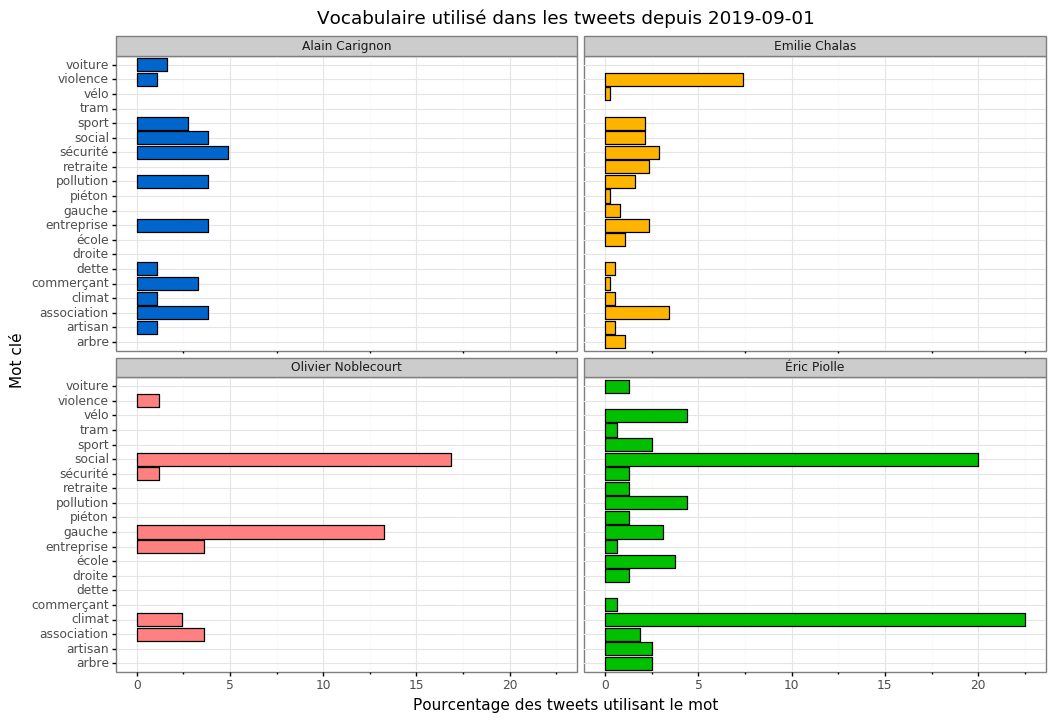

<ggplot: (8760270711970)>

In [12]:
keywords = [
    'arbre',
    'artisan',
    'association',
    'climat',
    'commerçant',
    'dette',
    'droite',
    'école',
    'entreprise',
    'gauche',
    'piéton',
    'pollution',
    'retraite',
    'sécurité',
    'social',
    'sport',
    'tram',
    'vélo',
    'violence',
    'voiture',
]

def get_keywords(df, keywords):
    tmp = tw.count_patterns(df, keywords)
    tmp['tag'] = tmp.apply(lambda row: users[row['login']], axis=1)
    nb_tweets = df.groupby('login')[['name']].count().reset_index()
    nb_tweets.columns = ['login', 'count']
    tmp = tmp.set_index('login').join(nb_tweets.set_index('login'))
    tmp['percent'] = tmp['tweet'] / tmp['count'] * 100
    diff = set(keywords) - set(tmp.pattern.unique())
    if len(diff) > 0:
        raise ValueError(f'Some keywords were missing: {diff}')
    return tmp

def plot_keywords(df, keywords):
    tmp = get_keywords(df, keywords)
    min_date = df['date'].min().date()
    plot = ggplot(tmp) +\
        geom_bar(aes(x='pattern', y='percent', fill='tag'), stat='identity', color='black', position='dodge') +\
        theme_bw() +\
        scale_fill_manual(colors) +\
        xlab('Mot clé') +\
        ylab('Pourcentage des tweets utilisant le mot') +\
        labs(fill='Mouvement') +\
        facet_wrap('name') +\
        theme(legend_position='none') +\
        ggtitle(f'Vocabulaire utilisé dans les tweets depuis {min_date}') +\
        scale_x_discrete(limits=keywords) +\
        coord_flip()

    plot.save('/tmp/figure.png', width=16, height=10)

    return plot

plot_keywords(df, keywords)

## Top of the most used words

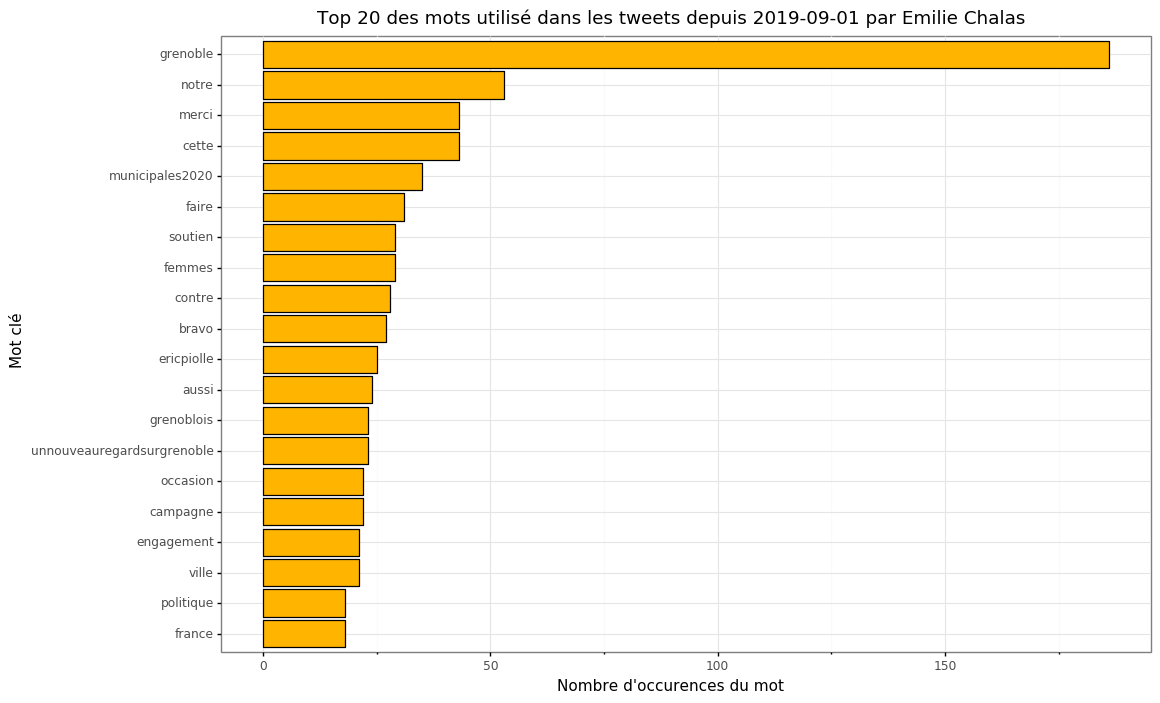

<ggplot: (-9223363276592472467)>

In [13]:
dump_list = ['http', 'https']

def plot_topwords(df, login, nb_words=20, min_length=5, dump_list=[]):
    dump_list = set(dump_list)
    df = df[df.login == login]
    name = df['name'].max()
    tmp = tw.count_words(df, min_length=min_length)
    tmp = tmp[~tmp['word'].isin(dump_list)]
    tmp = tmp.sort_values(by='count', ascending=False).head(n=nb_words)
    tmp = tmp.set_index('login').join(df[['name', 'tag', 'login']].drop_duplicates().set_index('login')).reset_index()  # adding some missing columns
    min_date = df['date'].min().date()
    tmp['word'] = pandas.Categorical(tmp['word'], categories=tmp.sort_values(by='count')['word'], ordered=True)
    plot = ggplot(tmp) +\
        geom_bar(aes(x='word', y='count', fill='tag'), stat='identity', color='black', position='dodge') +\
        theme_bw() +\
        scale_fill_manual(colors) +\
        xlab('Mot clé') +\
        ylab("Nombre d'occurences du mot") +\
        labs(fill='Mouvement') +\
        theme(legend_position='none') +\
        ggtitle(f'Top {nb_words} des mots utilisé dans les tweets depuis {min_date} par {name}') +\
        coord_flip()
    return plot

plot_topwords(df, 'EmilieCChalas', dump_list=dump_list)

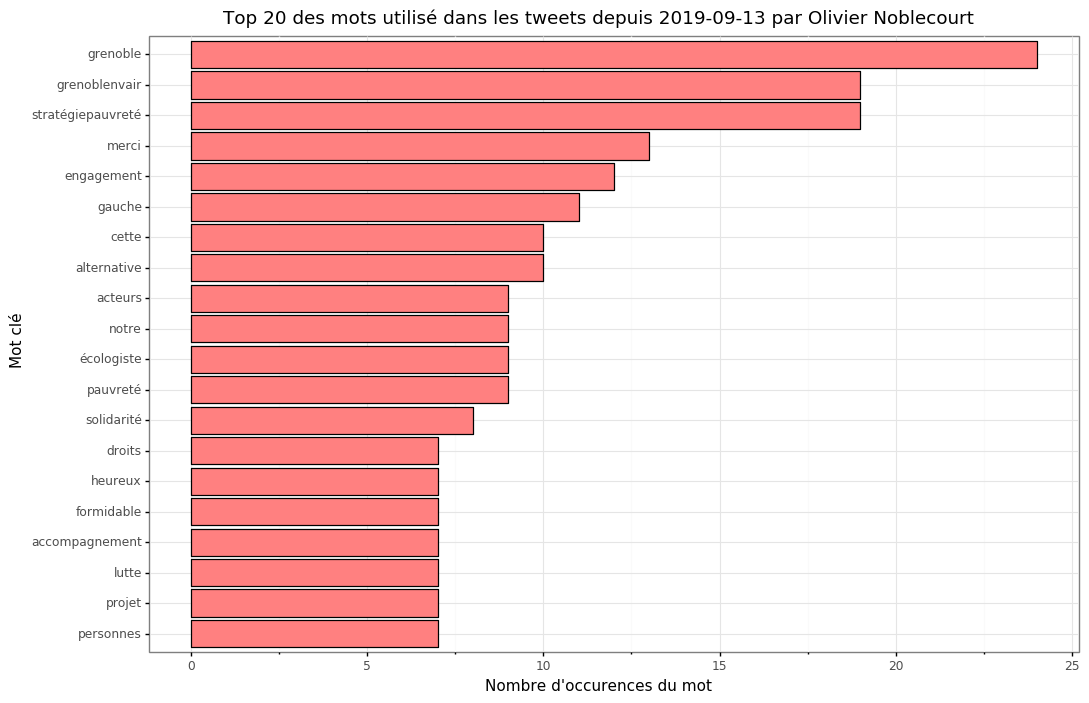

<ggplot: (-9223363276592520711)>

In [14]:
plot_topwords(df, 'onoblecourt', dump_list=dump_list)

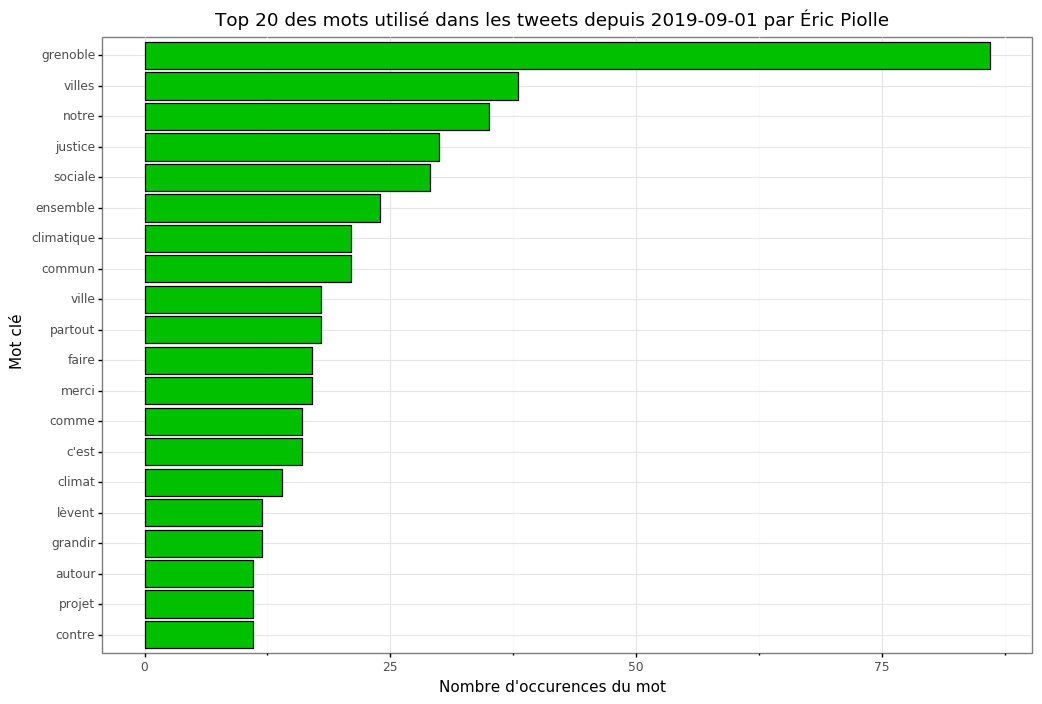

<ggplot: (-9223363276592474224)>

In [15]:
plot_topwords(df, 'EricPiolle', dump_list=dump_list)

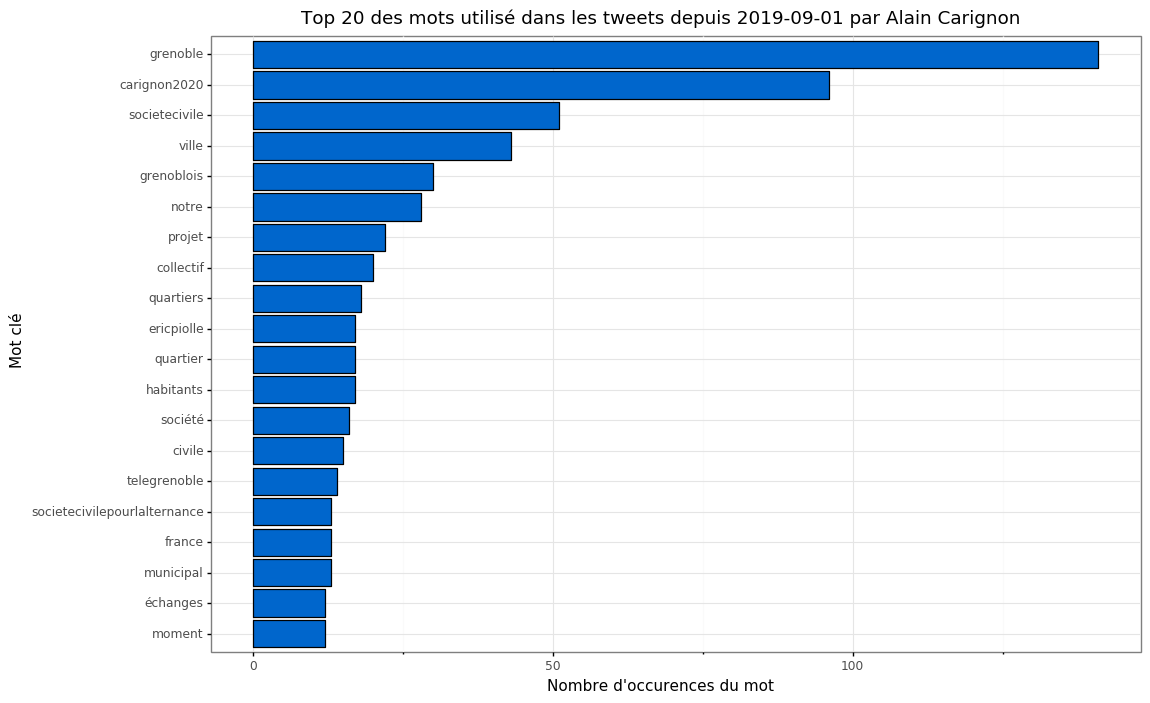

<ggplot: (8760270859805)>

In [16]:
plot_topwords(df, 'CarignonAlain', dump_list=dump_list)

## Top of the most used emojis

Switching to R for ggplot, as the emojis are apparently not supported by plotnine.

In [17]:
top_emojis = tw.count_words(df, split_func=tw.tweet_to_emojis, min_length=0)
top_emojis = top_emojis.set_index('login').join(df[['name', 'tag', 'login']].drop_duplicates().set_index('login')).reset_index()  # adding some missing columns
top_emojis['color'] = top_emojis.apply(lambda row: colors[row['tag']], axis=1)
top_emojis

,login,word,count,name,tag,color
0,CarignonAlain,🚨,16,Alain Carignon,Grenoble le Changement,#0066CC
1,CarignonAlain,➡,3,Alain Carignon,Grenoble le Changement,#0066CC
2,CarignonAlain,▶,32,Alain Carignon,Grenoble le Changement,#0066CC
3,CarignonAlain,🎈,22,Alain Carignon,Grenoble le Changement,#0066CC
4,CarignonAlain,👏,4,Alain Carignon,Grenoble le Changement,#0066CC
...,...,...,...,...,...,...
215,EricPiolle,☣,2,Éric Piolle,Grenoble en Commun,#00c000
216,EricPiolle,👏,1,Éric Piolle,Grenoble en Commun,#00c000
217,EricPiolle,🎿,1,Éric Piolle,Grenoble en Commun,#00c000
218,onoblecourt,💪,3,Olivier Noblecourt,Grenoble Nouvel Air,#ff8080


In [18]:
%load_ext rpy2.ipython

/home/tom/.cache/pypoetry/virtualenvs/twitter-data-NGoNO7rx-py3.7/lib/python3.7/site-packages/rpy2/robjects/pandas2ri.py:14: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import Index as PandasIndex
/home/tom/.cache/pypoetry/virtualenvs/twitter-data-NGoNO7rx-py3.7/lib/python3.7/site-packages/rpy2/robjects/pandas2ri.py:34: UserWarning: pandas >= 1.0 is not supported.
  warnings.warn('pandas >= 1.0 is not supported.')


R[write to console]: 
Attachement du package : ‘dplyr’


R[write to console]: The following objects are masked from ‘package:stats’:

    filter, lag


R[write to console]: The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




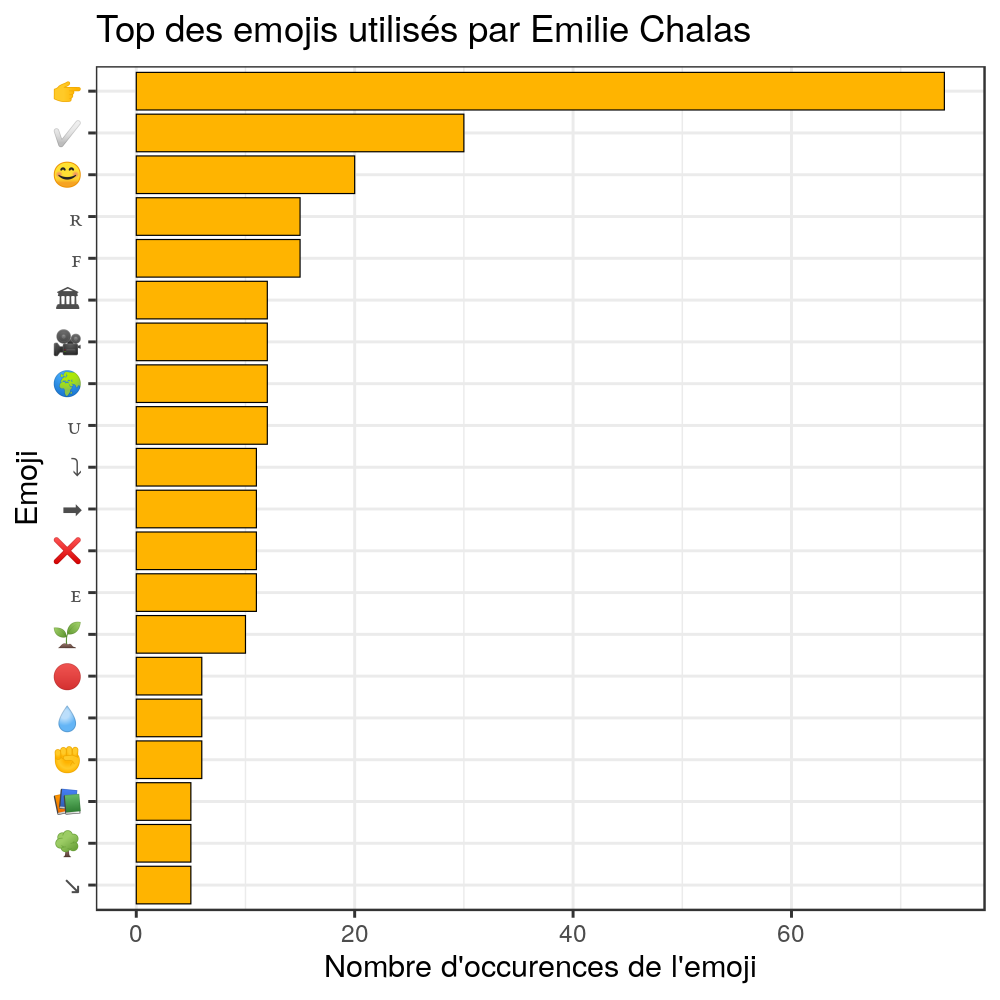

In [19]:
%%R -i top_emojis -w 5 -h 5 --units in -r 200

library(ggplot2)
library(dplyr)

plot_emoji <- function(df, user) {
    tmp = df %>% filter(login==user) %>% arrange(desc(count)) %>% head(n=20)
    color = tmp[1,"color"]
    name = tmp[1,"name"]
    plot = ggplot(tmp) +
        aes(x=reorder(word,count), y=count) + 
        geom_bar(stat='identity', fill=color, color="black", size=0.2) +
        theme_bw() +
        coord_flip() +
        ylab("Nombre d'occurences de l'emoji") +
        xlab('Emoji') +
        ggtitle(paste('Top des emojis utilisés par', name))
    ggsave(paste('/tmp/', user, '.png', sep=''), plot, width=6, height=4)
    return(plot)
}
plot_emoji(top_emojis, 'EmilieCChalas')

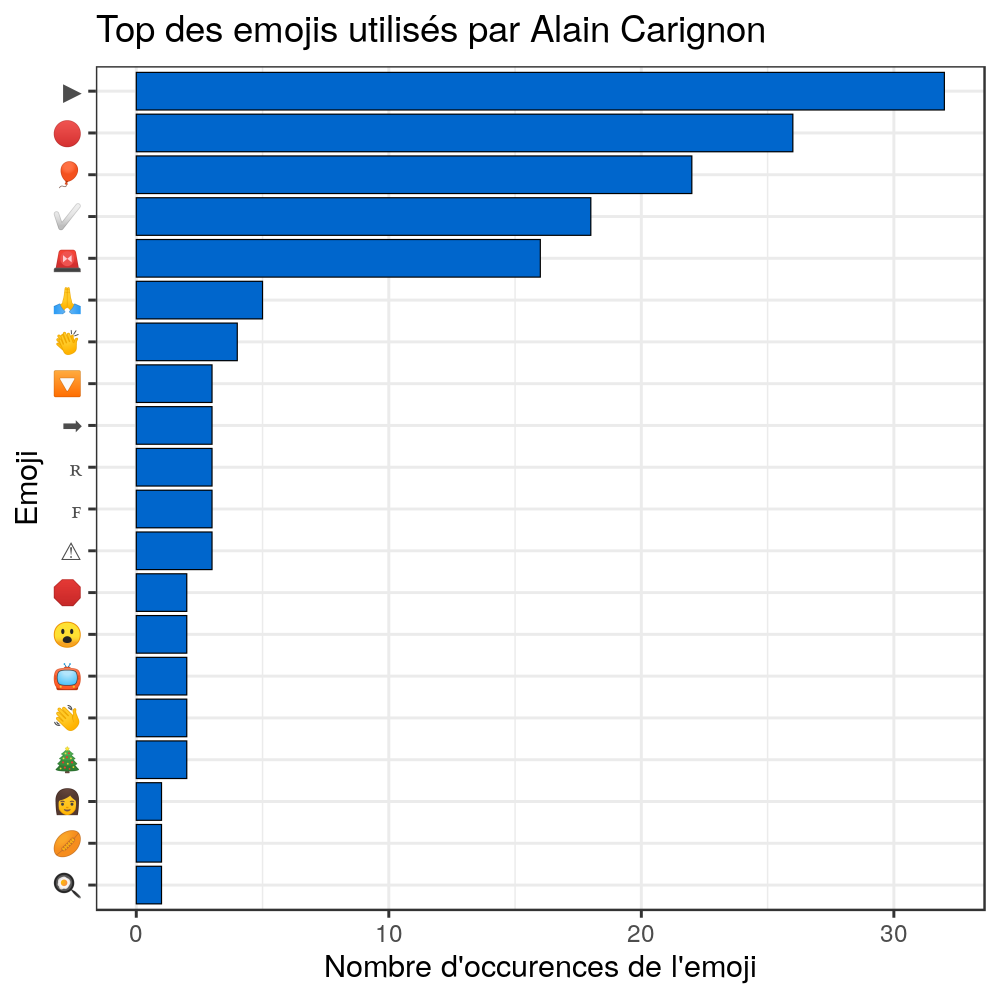

In [20]:
%%R -i top_emojis -w 5 -h 5 --units in -r 200

plot_emoji(top_emojis, 'CarignonAlain')

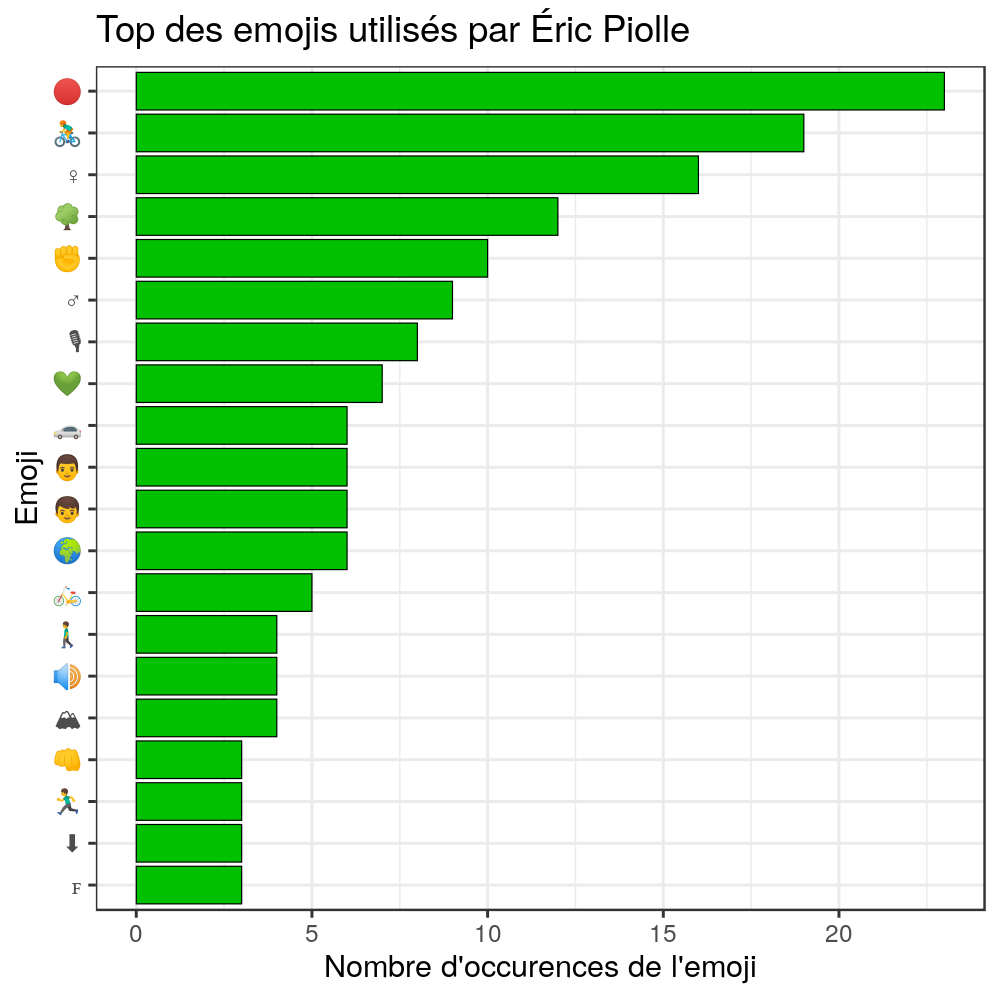

In [21]:
%%R -i top_emojis -w 5 -h 5 --units in -r 200

plot_emoji(top_emojis, 'EricPiolle')

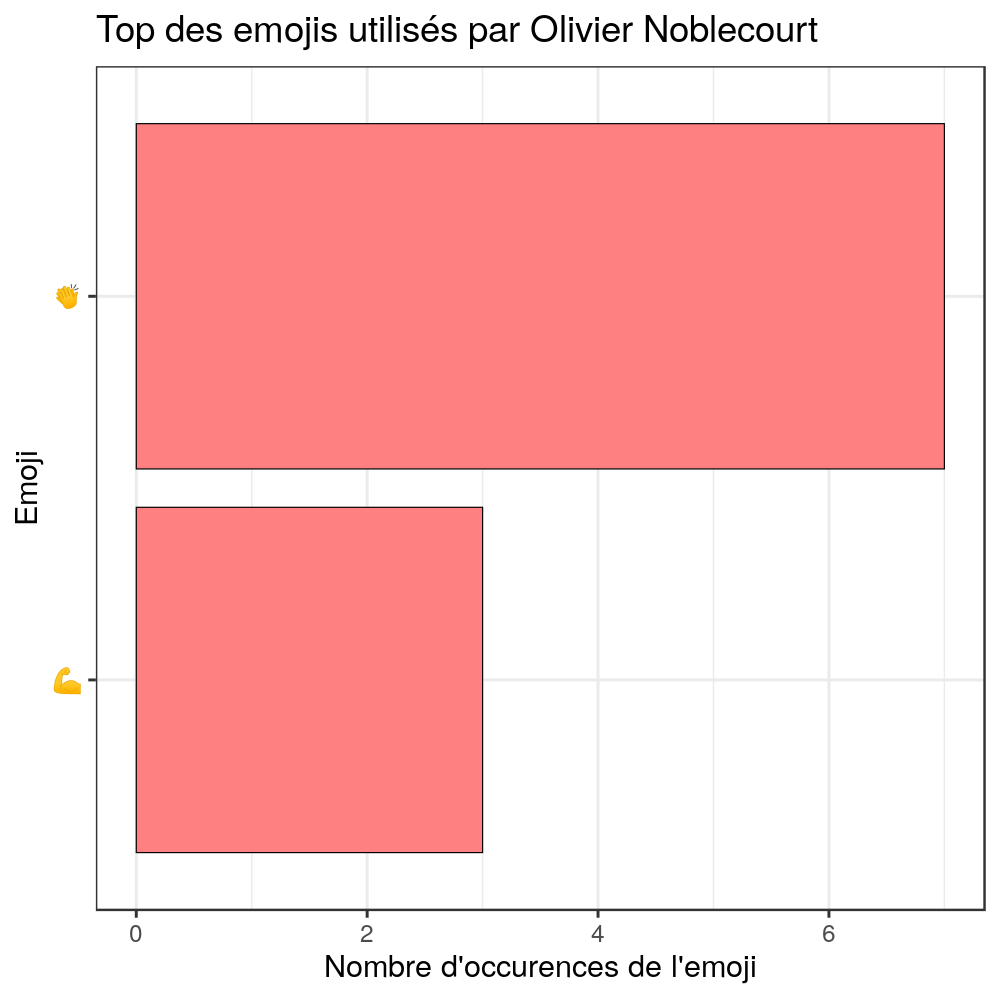

In [22]:
%%R -i top_emojis -w 5 -h 5 --units in -r 200

plot_emoji(top_emojis, 'onoblecourt')

## Percentage of tweets mentionning other candidates

In [23]:
names = df[['login', 'name']].drop_duplicates()
login_to_name = {row['login']:row['name'] for _, row in df.iterrows()}
login_to_name

{'EricPiolle': 'Éric Piolle',
 'EmilieCChalas': 'Emilie Chalas',
 'CarignonAlain': 'Alain Carignon',
 'onoblecourt': 'Olivier Noblecourt'}

In [24]:
users = list(df.login.unique())
mentions = tw.count_patterns(df, [f'@{usr}' for usr in users])
existing_pairs = [tuple(t[1]) for t in mentions[['login', 'pattern']].iterrows()]
all_pairs = [(usr1, f'@{usr2}') for usr1 in users for usr2 in users]
for login, pattern in set(all_pairs) - set(existing_pairs):
    mentions = mentions.append({'login': login, 'pattern': pattern, 'tweet': 0}, ignore_index=True)
mentions = mentions.set_index('login')
mentions['total'] = df.groupby('login')[['date']].count()
mentions = mentions.reset_index()
mentions['percent'] = mentions['tweet'] / mentions['total'] * 100
mentions['name'] = mentions.apply(lambda row: login_to_name[row['login']], axis=1)
mentions['mention'] = mentions.apply(lambda row: login_to_name[row['pattern'][1:]], axis=1)
mentions = mentions.reset_index()
mentions['text'] = round(mentions['percent'], 1).astype(str)
mentions['text'] += ' %'
mentions.loc[mentions['tweet'] == 0, 'text'] = ''
mentions

,index,login,name,tweet,pattern,total,percent,mention,text
0,0,EmilieCChalas,Emilie Chalas,25,@EricPiolle,379,6.596306,Éric Piolle,6.6 %
1,1,CarignonAlain,Alain Carignon,17,@EricPiolle,183,9.289617,Éric Piolle,9.3 %
2,2,EmilieCChalas,Emilie Chalas,5,@onoblecourt,379,1.319261,Olivier Noblecourt,1.3 %
3,3,onoblecourt,Olivier Noblecourt,3,@EricPiolle,83,3.614458,Éric Piolle,3.6 %
4,4,EmilieCChalas,Emilie Chalas,3,@CarignonAlain,379,0.791557,Alain Carignon,0.8 %
5,5,onoblecourt,Olivier Noblecourt,2,@EmilieCChalas,83,2.409639,Emilie Chalas,2.4 %
6,6,CarignonAlain,Alain Carignon,0,@EmilieCChalas,183,0.000000,Emilie Chalas,
7,7,EricPiolle,Éric Piolle,0,@EricPiolle,160,0.000000,Éric Piolle,
8,8,CarignonAlain,Alain Carignon,0,@CarignonAlain,183,0.000000,Alain Carignon,
9,9,EmilieCChalas,Emilie Chalas,0,@EmilieCChalas,379,0.000000,Emilie Chalas,


Again, because of some limitations of Python's ggplot implementation (it does not support `scale_x_discrete(position = "top")`), I need to switch to R.

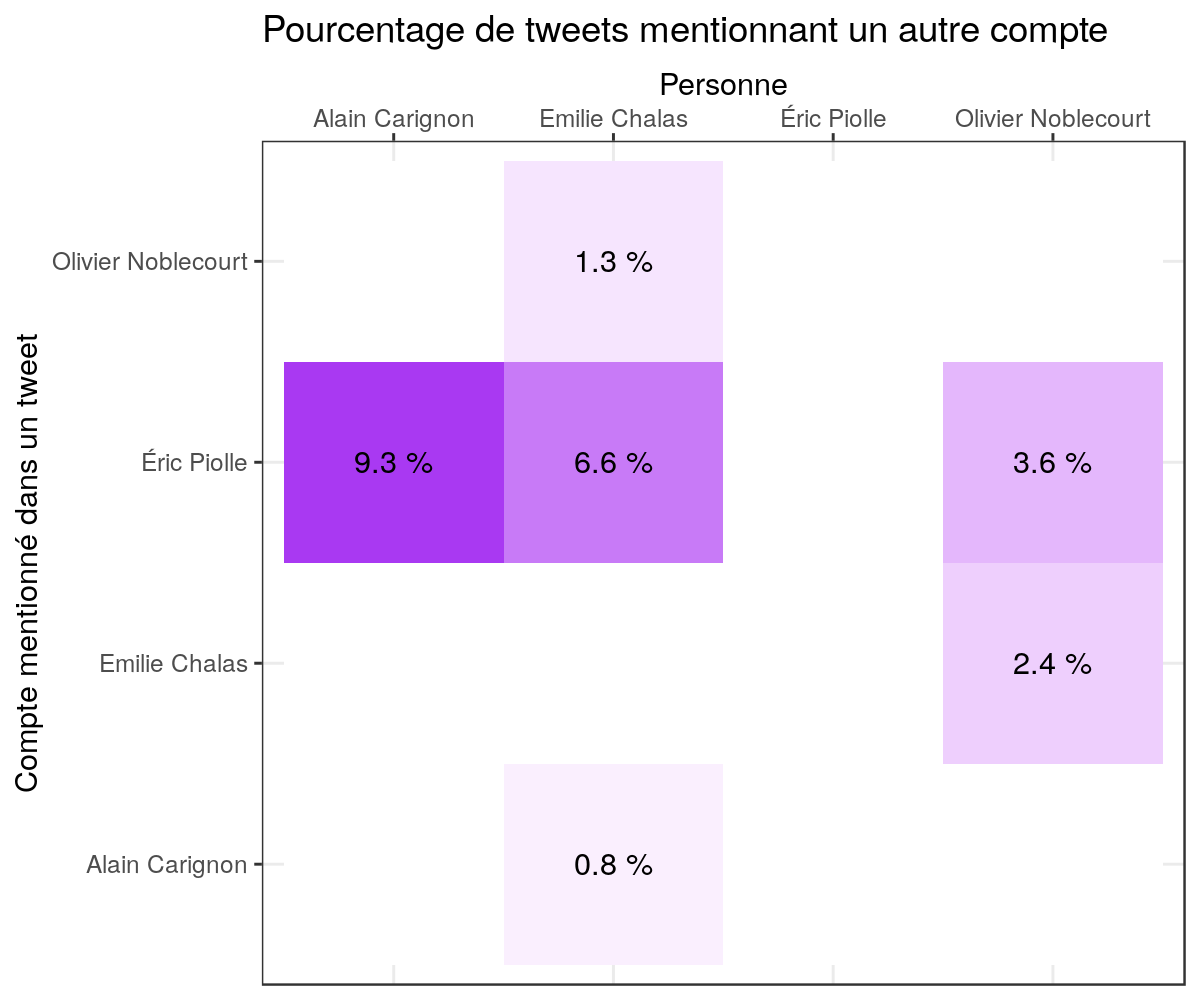

In [25]:
%%R -i mentions -w 6 -h 5 --units in -r 200

plot = ggplot(mentions) +
    aes(x=name, y=mention, fill=percent) +
    geom_tile() +
    theme_bw() +
    scale_fill_gradient2(high = "purple", limits=c(0, 10)) +
    scale_x_discrete(position = "top") +
    geom_text(aes(label = text), color = "black") +
    xlab('Personne') +
    ylab('Compte mentionné dans un tweet') +
    theme(legend.position='none') +
    ggtitle('Pourcentage de tweets mentionnant un autre compte')
ggsave('/tmp/mentions.png', plot, width=6, height=5)
plot